In [4]:
import pandas as pd

data = {'visit_id':  ['James', 'Mike', 'Tommy', 'Meguy', 'Mia'],
        'date': ['2019-04-04', '2019-04-04', '2019-04-04', '2019-04-04', '2019-04-04'],
        'variant': ['A', 'B', 'B', 'A', 'B'],
        'conversion': [0, 1, 0, 1, 1],
        'revenue': [0.00, 22.80, 0.00, 12.90, 37.5],
        }

df = pd.DataFrame (data, columns = ['visit_id','date', 'variant', 'conversion', 'revenue'])

print (df)

  visit_id        date variant  conversion  revenue
0    James  2019-04-04       A           0      0.0
1     Mike  2019-04-04       B           1     22.8
2    Tommy  2019-04-04       B           0      0.0
3    Meguy  2019-04-04       A           1     12.9
4      Mia  2019-04-04       B           1     37.5


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pymc3 as pm

def data_split(df):
    variant = df[df['variant']!='A']
    default = df[df['variant']=='A']

    conv_variant = df[(df['variant']!='A') & (df['conversion']>0 )]
    conv_default = df[(df['variant']=='A') & (df['conversion']>0)]

    default = default['conversion']
    variant = variant['conversion']
    rev_default = conv_default['revenue']
    rev_variant = conv_variant['revenue']
    return [default,variant,rev_default,rev_variant]
      
dataframe = df
observations = data_split(dataframe);

In [10]:
observations[0]

0    0
3    1
Name: conversion, dtype: int64

In [9]:
observations[1]

1    1
2    0
4    1
Name: conversion, dtype: int64

In [25]:
with pm.Model() as ab_model:
  #Conversion a priori
  a_prior=pm.distributions.continuous.Beta('conversionA', alpha=0.1, beta=0.1)
  b_prior=pm.distributions.continuous.Beta('conversionB', alpha=0.1, beta=0.1)

  #Revenues a priori - Can't be beta - more complex
  rev_a_prior=pm.distributions.continuous.Gamma('revenueA', alpha=0.1, beta=0.1)
  rev_b_prior=pm.distributions.continuous.Gamma('revenueB', alpha=0.1, beta=0.1)
  
  pm.Bernoulli('likelihoodA', a_prior, observed=observations[0])
  pm.Bernoulli('likelihoodB', b_prior, observed=observations[1])
  pm.Poisson('likelihoodRevenueA', rev_a_prior, observed=observations[2])
  pm.Poisson('likelihoodRevenueB', rev_b_prior, observed=observations[3])

  conv_a = pm.Deterministic('conversion_A', a_prior)
  conv_b = pm.Deterministic('conversion_B', b_prior)
  
  conv_rev_a = pm.Deterministic('conversionRevenueA', a_prior*rev_a_prior)
  conv_rev_b = pm.Deterministic('conversionRevenueB', b_prior*rev_b_prior)

  pm.Deterministic('lift', b_prior - a_prior)
  pm.Deterministic('revenueLift', conv_rev_b - conv_rev_a)
    
  step = pm.Slice()
  trace = pm.sample(1000, step=step)

<class 'pymc3.model.TransformedRV'>


c:\users\sabyna\project\eni\env\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [revenueB]
>Slice: [revenueA]
>Slice: [conversionB]
>Slice: [conversionA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


In [77]:
difference_rev=trace['conversionRevenueB']-trace['conversionRevenueA']

In [79]:
difference_conversion=trace['conversionB']-trace['conversionA']

In [78]:
#probability of 14% increase by group B revenue and conversion
100*len(difference_rev[difference_rev>0.14])*1.0/len(difference_rev)

93.575

In [85]:
#probability of 100% increase by group B revenue and conversion
100*len(difference_rev[difference_rev>1])*1.0/len(difference_rev)

92.025

In [81]:
#probability of 6% increase by group B revenue and conversion
100*len(difference_conversion[difference_conversion>0.6])*1.0/len(difference_conversion)

12.2

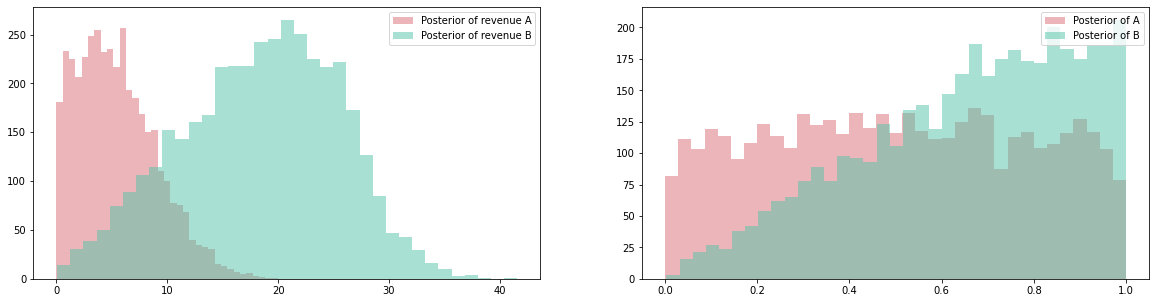

In [86]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2,1)
plt.hist(trace['conversionRevenueA'][:], bins=35, histtype='stepfilled', 
color='#da6d75', label='Posterior of revenue A',alpha=0.5)
plt.legend()
plt.hist(trace['conversionRevenueB'][:], bins=35, histtype='stepfilled',
color='#52c4a8', label='Posterior of revenue B',alpha=0.5)
plt.legend()
plt.subplot(1, 2,2)
plt.hist(trace['conversion_A'][:], bins=35, histtype='stepfilled',
color='#da6d75', label='Posterior of A',alpha=0.5)
plt.legend()
plt.hist(trace['conversion_B'][:], bins=35, histtype='stepfilled',
color='#52c4a8', label='Posterior of B',alpha=0.5)
plt.legend()
plt.show()